# FuseMap Tutorial II: Integrating Spatial Transcriptomics Data Across Different Technology Platforms

In this tutorial, we'll demonstrate how to use FuseMap to integrate spatial transcriptomics data from different technology platforms - specifically, combining image-based (STARmap) and sequencing-based (Slide-seq) technologies. This integration is particularly challenging and important because:

1. Different technologies capture spatial information at different resolutions
2. The data formats and characteristics vary significantly between platforms
3. The gene capture efficiency and coverage differ between methods

We'll walk through each step carefully, explaining the rationale and technical details along the way.

## 1. Data preparation

For this tutorial, we'll use mouse brain data from two different platforms:

- STARmap data: A high-resolution image-based spatial transcriptomics method (Shi et al., [Nature paper](https://www.nature.com/articles/s41586-023-06569-5#data-availability))
- Slide-seq data: A sequencing-based spatial transcriptomics method with high throughput (Langlieb et al., [Nature paper](https://www.nature.com/articles/s41586-023-06818-7#data-availability))

Both datasets are from mouse brain tissue, which allows us to demonstrate cross-platform integration while maintaining biological relevance.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from fusemap import seed_all, setup_logging, ModelType
from fusemap.spatial_integrate import spatial_integrate
import logging
import pandas as pd
from time import time

seed_all(0)
start_time = time()
# Set plotting style
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 12

## 2. Data Loading and Preprocessing

When working with different technology platforms, careful preprocessing is crucial. Each platform has its own data characteristics:

In [3]:
# Set paths to data
data_dir_list = [
    '/n/home11/mingzeyuan/FuseMap/data/02_imaging_sequencing_data/raw_data/starmap.h5ad',
    '/n/home11/mingzeyuan/FuseMap/data/02_imaging_sequencing_data/sequencing_test_data/stereoseq_mousebrain.h5ad'
]
output_dir = '/n/netscratch/nali_lab_seas/Everyone/mingze/FuseMap_imputation/workspace/integrate_starmap_stereoseq'
os.makedirs(output_dir, exist_ok=True)

In [4]:
args = edict(dict(output_save_dir=output_dir, 
                  keep_celltype="", 
                  keep_tissueregion="", 
                  use_llm_gene_embedding="false", 
                  pretrain_model_path=""))

In [5]:
setup_logging(args.output_save_dir)

arg_dict = vars(args)
dict_pd = {}
for keys in arg_dict.keys():
    dict_pd[keys] = [arg_dict[keys]]
pd.DataFrame(dict_pd).to_csv(args.output_save_dir  + "config.csv", index=False)
logging.info("\n\n\033[95mArguments:\033[0m \n%s\n\n", vars(args))
logging.info("\n\n\033[95mArguments:\033[0m \n%s\n\n", vars(ModelType))

2025-03-20 20:44:55,414 - INFO - 

Arguments: 
{'output_save_dir': '/n/netscratch/nali_lab_seas/Everyone/mingze/FuseMap_imputation/workspace/integrate_starmap_stereoseq', 'keep_celltype': '', 'keep_tissueregion': '', 'use_llm_gene_embedding': 'false', 'pretrain_model_path': ''}


2025-03-20 20:44:55,415 - INFO - 

Arguments: 
{'_generate_next_value_': <function Enum._generate_next_value_ at 0x145e7e3ac0d0>, '__module__': 'fusemap.config', '__doc__': 'An enumeration.', '_member_names_': ['pca_dim', 'hidden_dim', 'latent_dim', 'dropout_rate', 'n_epochs', 'learning_rate', 'optim_kw', 'use_input', 'lambda_ae_single', 'align_noise_coef', 'lr_patience_pretrain', 'lr_factor_pretrain', 'lr_limit_pretrain', 'patience_limit_final', 'lr_patience_final', 'EPS', 'TRAIN_WITHOUT_EVAL', 'USE_REFERENCE_PCT', 'verbose', 'use_key'], '_member_map_': {'pca_dim': <ModelType.pca_dim: 50>, 'hidden_dim': <ModelType.hidden_dim: 512>, 'latent_dim': <ModelType.latent_dim: 64>, 'dropout_rate': <ModelType.dropout_r

### Loading and Processing the Data
For cross-platform integration, we need to handle the spatial coordinates carefully. Note that:
- STARmap provides cell-level coordinates
- Slide-seq provides bead/spot coordinates
We will standardize these coordinates while preserving their relative positions:

In [6]:
X_input = []
for ind, data_dir in enumerate(data_dir_list):
    print(f"Loading {data_dir}")
    data = sc.read_h5ad(data_dir)
    
    # Handle spatial coordinates with platform-specific considerations
    if "x" not in data.obs.columns:
        if "col" in data.obs.columns and "row" in data.obs.columns:
            data.obs["x"] = data.obs["col"]
            data.obs["y"] = data.obs["row"]
        elif "spatial" in data.obsm.keys():
            data.obs["x"] = data.obsm["spatial"][:,0]
            data.obs["y"] = data.obsm["spatial"][:,1]
        elif 'Raw_Slideseq_X' in data.obs.columns and 'Raw_Slideseq_Y' in data.obs.columns:
            data.obs["x"] = data.obs['Raw_Slideseq_X']
            data.obs["y"] = data.obs['Raw_Slideseq_Y']
        else:
            raise ValueError(f"Spatial coordinates not found in expected format for {data_dir}")
    
    # Add dataset-specific metadata
    data.obs['name'] = f'section{ind}'
    data.obs['file_name'] = os.path.basename(data_dir)
    data.obs['platform'] = 'STARmap' if 'starmap' in data_dir.lower() else 'Slide-seq'
    
    print(f"Loaded {data.shape[0]} spots/cells with {data.shape[1]} genes from {data.obs['platform']}")
    X_input.append(data)

# Set integration parameters
# Use Delaunay triangulation for STARmap (cell-level) and KNN for Slide-seq (spot-level)
kneighbor = ["delaunay", "knn"]
input_identity = ["ST", "ST"]
print(f"Loaded {len(X_input)} datasets from different platforms")

Loading /n/home11/mingzeyuan/FuseMap/data/02_imaging_sequencing_data/raw_data/starmap.h5ad
Loaded 43341 spots/cells with 1022 genes from 359676    STARmap
359677    STARmap
359678    STARmap
359679    STARmap
359680    STARmap
           ...   
404555    STARmap
404556    STARmap
404557    STARmap
404558    STARmap
404559    STARmap
Name: platform, Length: 43341, dtype: object
Loading /n/home11/mingzeyuan/FuseMap/data/02_imaging_sequencing_data/sequencing_test_data/stereoseq_mousebrain.h5ad
Loaded 50140 spots/cells with 25879 genes from Cell_1        Slide-seq
Cell_1000     Slide-seq
Cell_10000    Slide-seq
Cell_10001    Slide-seq
Cell_10002    Slide-seq
                ...    
Cell_9994     Slide-seq
Cell_9996     Slide-seq
Cell_9997     Slide-seq
Cell_9998     Slide-seq
Cell_9999     Slide-seq
Name: platform, Length: 50140, dtype: object
Loaded 2 datasets from different platforms


## 3. Cross-platform Integration

Now we'll perform the integration using FuseMap. The algorithm will:
1. Learn platform-invariant features
2. Preserve spatial relationships specific to each technology
3. Create a unified representation of the tissue

In [7]:
# Run the integration
spatial_integrate(X_input, args, kneighbor, input_identity)

2025-03-16 23:30:26,338 - INFO - 

---------------------------------- Preprocess adata ----------------------------------

2025-03-16 23:30:55,241 - INFO - 

---------------------------------- Construct graph adata ----------------------------------

2025-03-16 23:30:58,052 - INFO - 

---------------------------------- Process graph adata ----------------------------------

2025-03-16 23:31:11,101 - INFO - 

number of genes in each section:[1022, 23352], Number of all genes: 23395.

2025-03-16 23:31:14,734 - INFO - 

Loading snapshot

2025-03-16 23:31:14,811 - INFO - 

Resuming training from snapshot at pretrain Epoch 14, final epoch 0

2025-03-16 23:31:14,947 - INFO - 

---------------------------------- Phase 1. Pretrain FuseMap model ----------------------------------

100%|██████████| 15/15 [31:23<00:00, 125.56s/it]
2025-03-17 00:02:38,356 - INFO - 

File name changed in the end

2025-03-17 00:02:38,358 - INFO - 

---------------------------------- Phase 2. Evaluate pretrained Fuse

In [8]:
print(f"Training time elapsed: {(time() - start_time)/60:.2f} min")

Training time elapsed: 64.52 min


## 4. Visualization

### read single-cell embedding

Text(0.5, 1.0, 'Single-cell embedding, colored by sample ID')

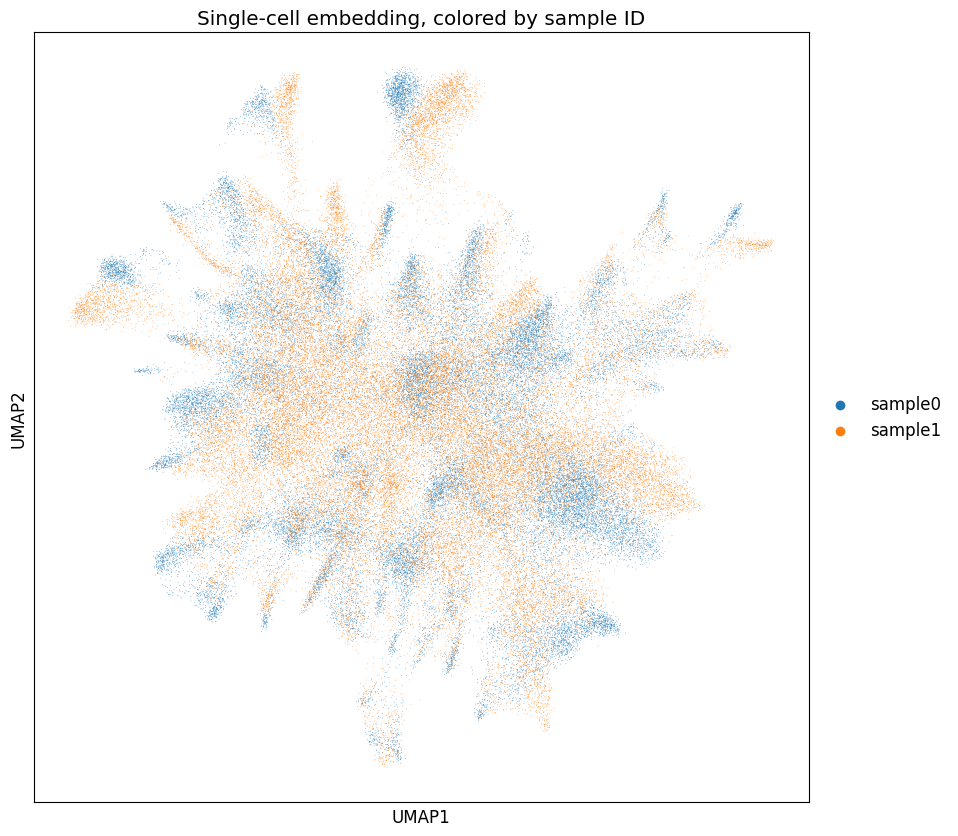

In [9]:
ad_embed=sc.read_h5ad(os.path.join(output_dir, 'ad_celltype_embedding.h5ad'))
sc.pp.neighbors(ad_embed, n_neighbors=50,use_rep='X')
sc.tl.umap(ad_embed)
ax = sc.pl.umap(ad_embed,color='batch',size=1, show=False)
ax.set_title('Single-cell embedding, colored by sample ID')

### read spatial embedding

Text(0.5, 1.0, 'Single-cell embedding, colored by sample ID')

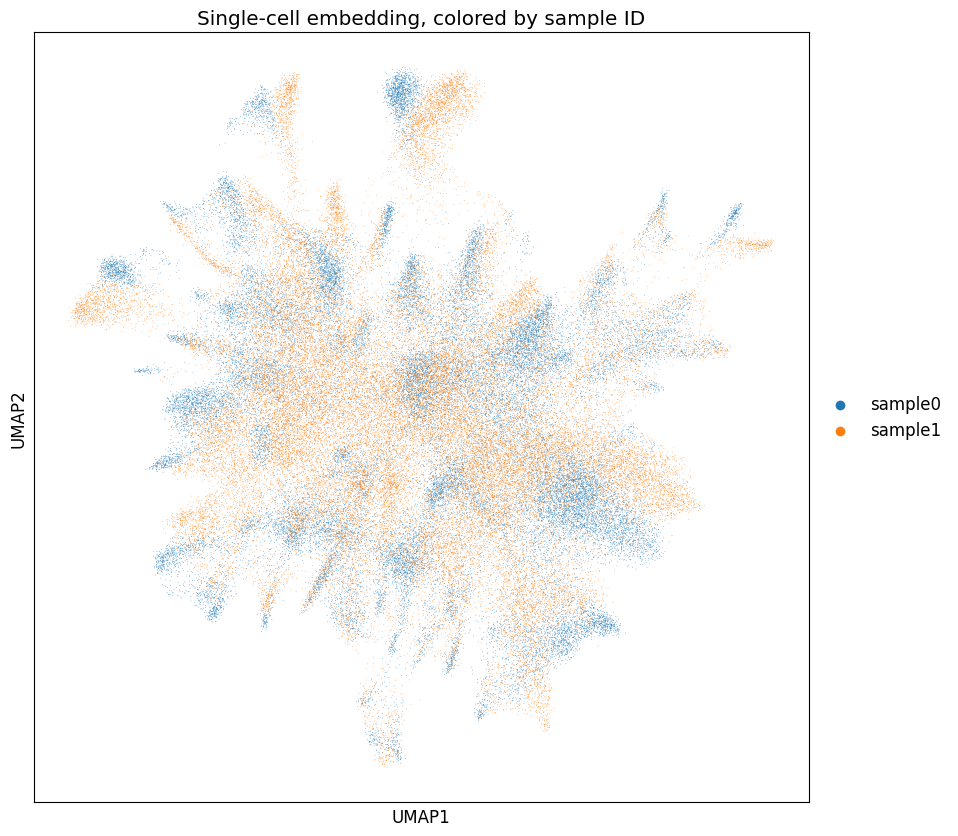

In [10]:
ad_embed=sc.read_h5ad(os.path.join(output_dir, 'ad_celltype_embedding.h5ad'))
sc.pp.neighbors(ad_embed, n_neighbors=50,use_rep='X')
sc.tl.umap(ad_embed)
ax = sc.pl.umap(ad_embed,color='batch',size=1, show=False)
ax.set_title('Single-cell embedding, colored by sample ID')

### read gene embedding

Text(0.5, 1.0, 'Single-cell embedding, colored by sample ID')

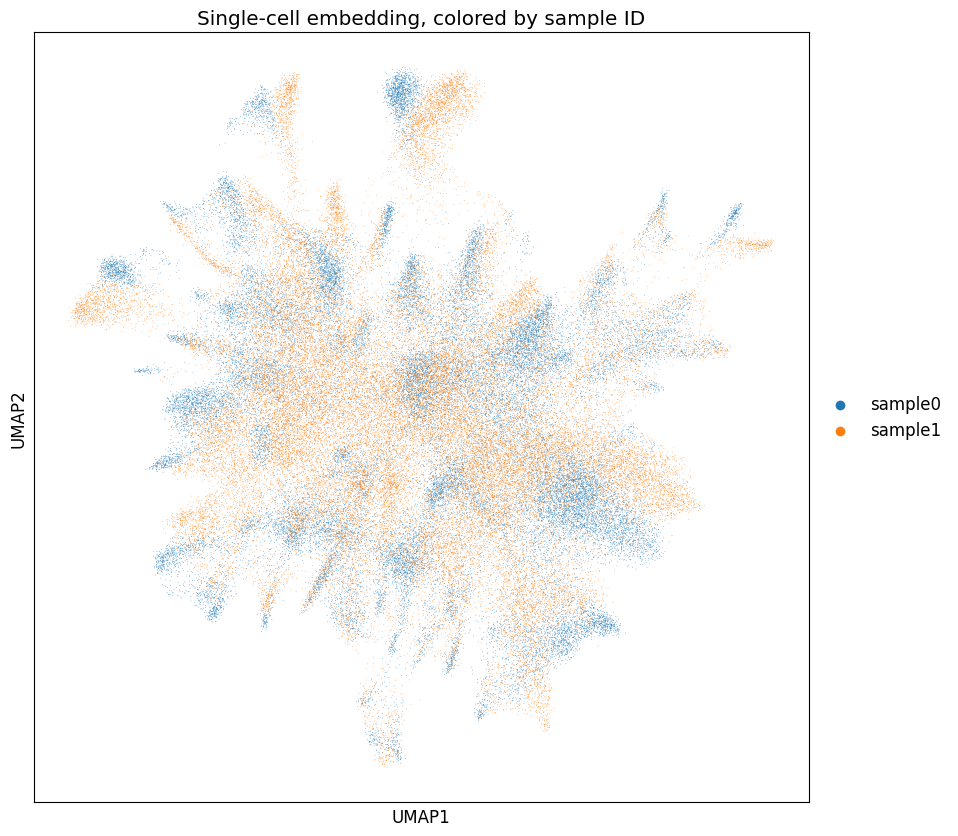

In [11]:
ad_embed=sc.read_h5ad(os.path.join(output_dir, 'ad_celltype_embedding.h5ad'))
sc.pp.neighbors(ad_embed, n_neighbors=50,use_rep='X')
sc.tl.umap(ad_embed)
ax = sc.pl.umap(ad_embed,color='batch',size=1, show=False)
ax.set_title('Single-cell embedding, colored by sample ID')

## 5. Cell deconvolution in sequencing-based data

In [6]:
from fusemap.deconvolution import get_cell_spot_embedding, get_representative_embeddings, optimize_cell_spot_assignment, evaluate_topk_accuracy, cell_type_mapping_starmap_stereomap
import torch
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
import numpy as np
import json
n_prototypes = 5
lambda_reg = 0.1

In [7]:
start_time = time()
ad_cell_embd = sc.read_h5ad(os.path.join(output_dir, 'ad_celltype_embedding.h5ad'))
ad_sc = sc.read_h5ad(data_dir_list[0])
ad_sp = sc.read_h5ad(data_dir_list[1])
ad_cell_embd.obs['cell_or_spot'] = 'unknown'
# Assign values conditionally based on the 'batch' column
ad_cell_embd.obs.loc[ad_cell_embd.obs['batch'] == 'sample0', 'cell_or_spot'] = 'cell'
ad_cell_embd.obs.loc[ad_cell_embd.obs['batch'] == 'sample1', 'cell_or_spot'] = 'spot'

# Extract embeddings and cell type information
cell_embd, spot_embd, cell_type = get_cell_spot_embedding(ad_cell_embd, cell_or_spot_column='cell_or_spot', cell_type_column='gtTaxonomyRank4')
cell_label = pd.Categorical(cell_type).codes # Cell types for merscope

# Obtain representative embeddings for each cell type
Z_representative = get_representative_embeddings(cell_embd, cell_label, n_prototypes=n_prototypes, method="kmeans")

# Convert numpy arrays to torch tensors
Z_prototypes = torch.tensor(Z_representative, dtype=torch.float32, device=device)
Z_spots = torch.tensor(spot_embd, dtype=torch.float32, device=device)

In [8]:
# Optimize the cell-spot assignment matrix
M_final = optimize_cell_spot_assignment(Z_prototypes, Z_spots, lr=0.02, num_epochs=1000, device=device)

# Save the final assignment matrix
suffix = f'{n_prototypes}_{lambda_reg}'
np.save(os.path.join(output_dir, f"cell_spot_assignment_{suffix}.npy"), M_final)

img_cate = pd.Categorical(ad_cell_embd.obs[ad_cell_embd.obs['batch'] == 'sample0']['gtTaxonomyRank4']).categories.tolist()

ground_truth = ad_sp.obs['gt_cell_type_main'].tolist()

res = {}
for k in [1, 2, 3, 4, 5]:
    res[k] = evaluate_topk_accuracy(M_final, cell_type_mapping_starmap_stereomap, img_cate, ground_truth, ad_sp.X.shape[0], k=k)
    
res['time'] = time() - start_time

with open(os.path.join(output_dir, f"deconv_accuracy_{suffix}.json"), 'w') as f:
    json.dump(res, f, indent=4)

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 44/1000 [00:00<00:09, 98.72it/s]

Epoch 0, Total Loss: 0.9737, Reconstruction Loss: 0.6509, Regularization Loss: 0.0323


 15%|█▌        | 150/1000 [00:01<00:04, 210.45it/s]

Epoch 100, Total Loss: 0.6681, Reconstruction Loss: 0.3957, Regularization Loss: 0.0272


 25%|██▍       | 247/1000 [00:01<00:02, 252.81it/s]

Epoch 200, Total Loss: 0.4322, Reconstruction Loss: 0.2803, Regularization Loss: 0.0152


 35%|███▍      | 347/1000 [00:01<00:02, 264.50it/s]

Epoch 300, Total Loss: 0.3714, Reconstruction Loss: 0.2824, Regularization Loss: 0.0089


 45%|████▍     | 447/1000 [00:02<00:02, 267.23it/s]

Epoch 400, Total Loss: 0.3556, Reconstruction Loss: 0.2857, Regularization Loss: 0.0070


 55%|█████▍    | 547/1000 [00:02<00:01, 268.15it/s]

Epoch 500, Total Loss: 0.3499, Reconstruction Loss: 0.2871, Regularization Loss: 0.0063


 65%|██████▍   | 647/1000 [00:02<00:01, 268.41it/s]

Epoch 600, Total Loss: 0.3472, Reconstruction Loss: 0.2878, Regularization Loss: 0.0059


 75%|███████▍  | 747/1000 [00:03<00:00, 268.55it/s]

Epoch 700, Total Loss: 0.3457, Reconstruction Loss: 0.2881, Regularization Loss: 0.0058


 85%|████████▍ | 847/1000 [00:03<00:00, 268.55it/s]

Epoch 800, Total Loss: 0.3447, Reconstruction Loss: 0.2883, Regularization Loss: 0.0056


 95%|█████████▍| 947/1000 [00:04<00:00, 268.58it/s]

Epoch 900, Total Loss: 0.3441, Reconstruction Loss: 0.2884, Regularization Loss: 0.0056


100%|██████████| 1000/1000 [00:04<00:00, 227.90it/s]


Optimization completed!


100%|██████████| 50140/50140 [00:00<00:00, 221584.37it/s]


Top-1 accuracy: 45.5%, 15983/35159


100%|██████████| 50140/50140 [00:00<00:00, 206710.19it/s]


Top-2 accuracy: 48.5%, 20337/41919


100%|██████████| 50140/50140 [00:00<00:00, 192072.78it/s]


Top-3 accuracy: 51.4%, 22677/44152


100%|██████████| 50140/50140 [00:00<00:00, 182591.89it/s]


Top-4 accuracy: 54.8%, 24652/44978


100%|██████████| 50140/50140 [00:00<00:00, 170966.44it/s]


Top-5 accuracy: 58.4%, 26484/45315


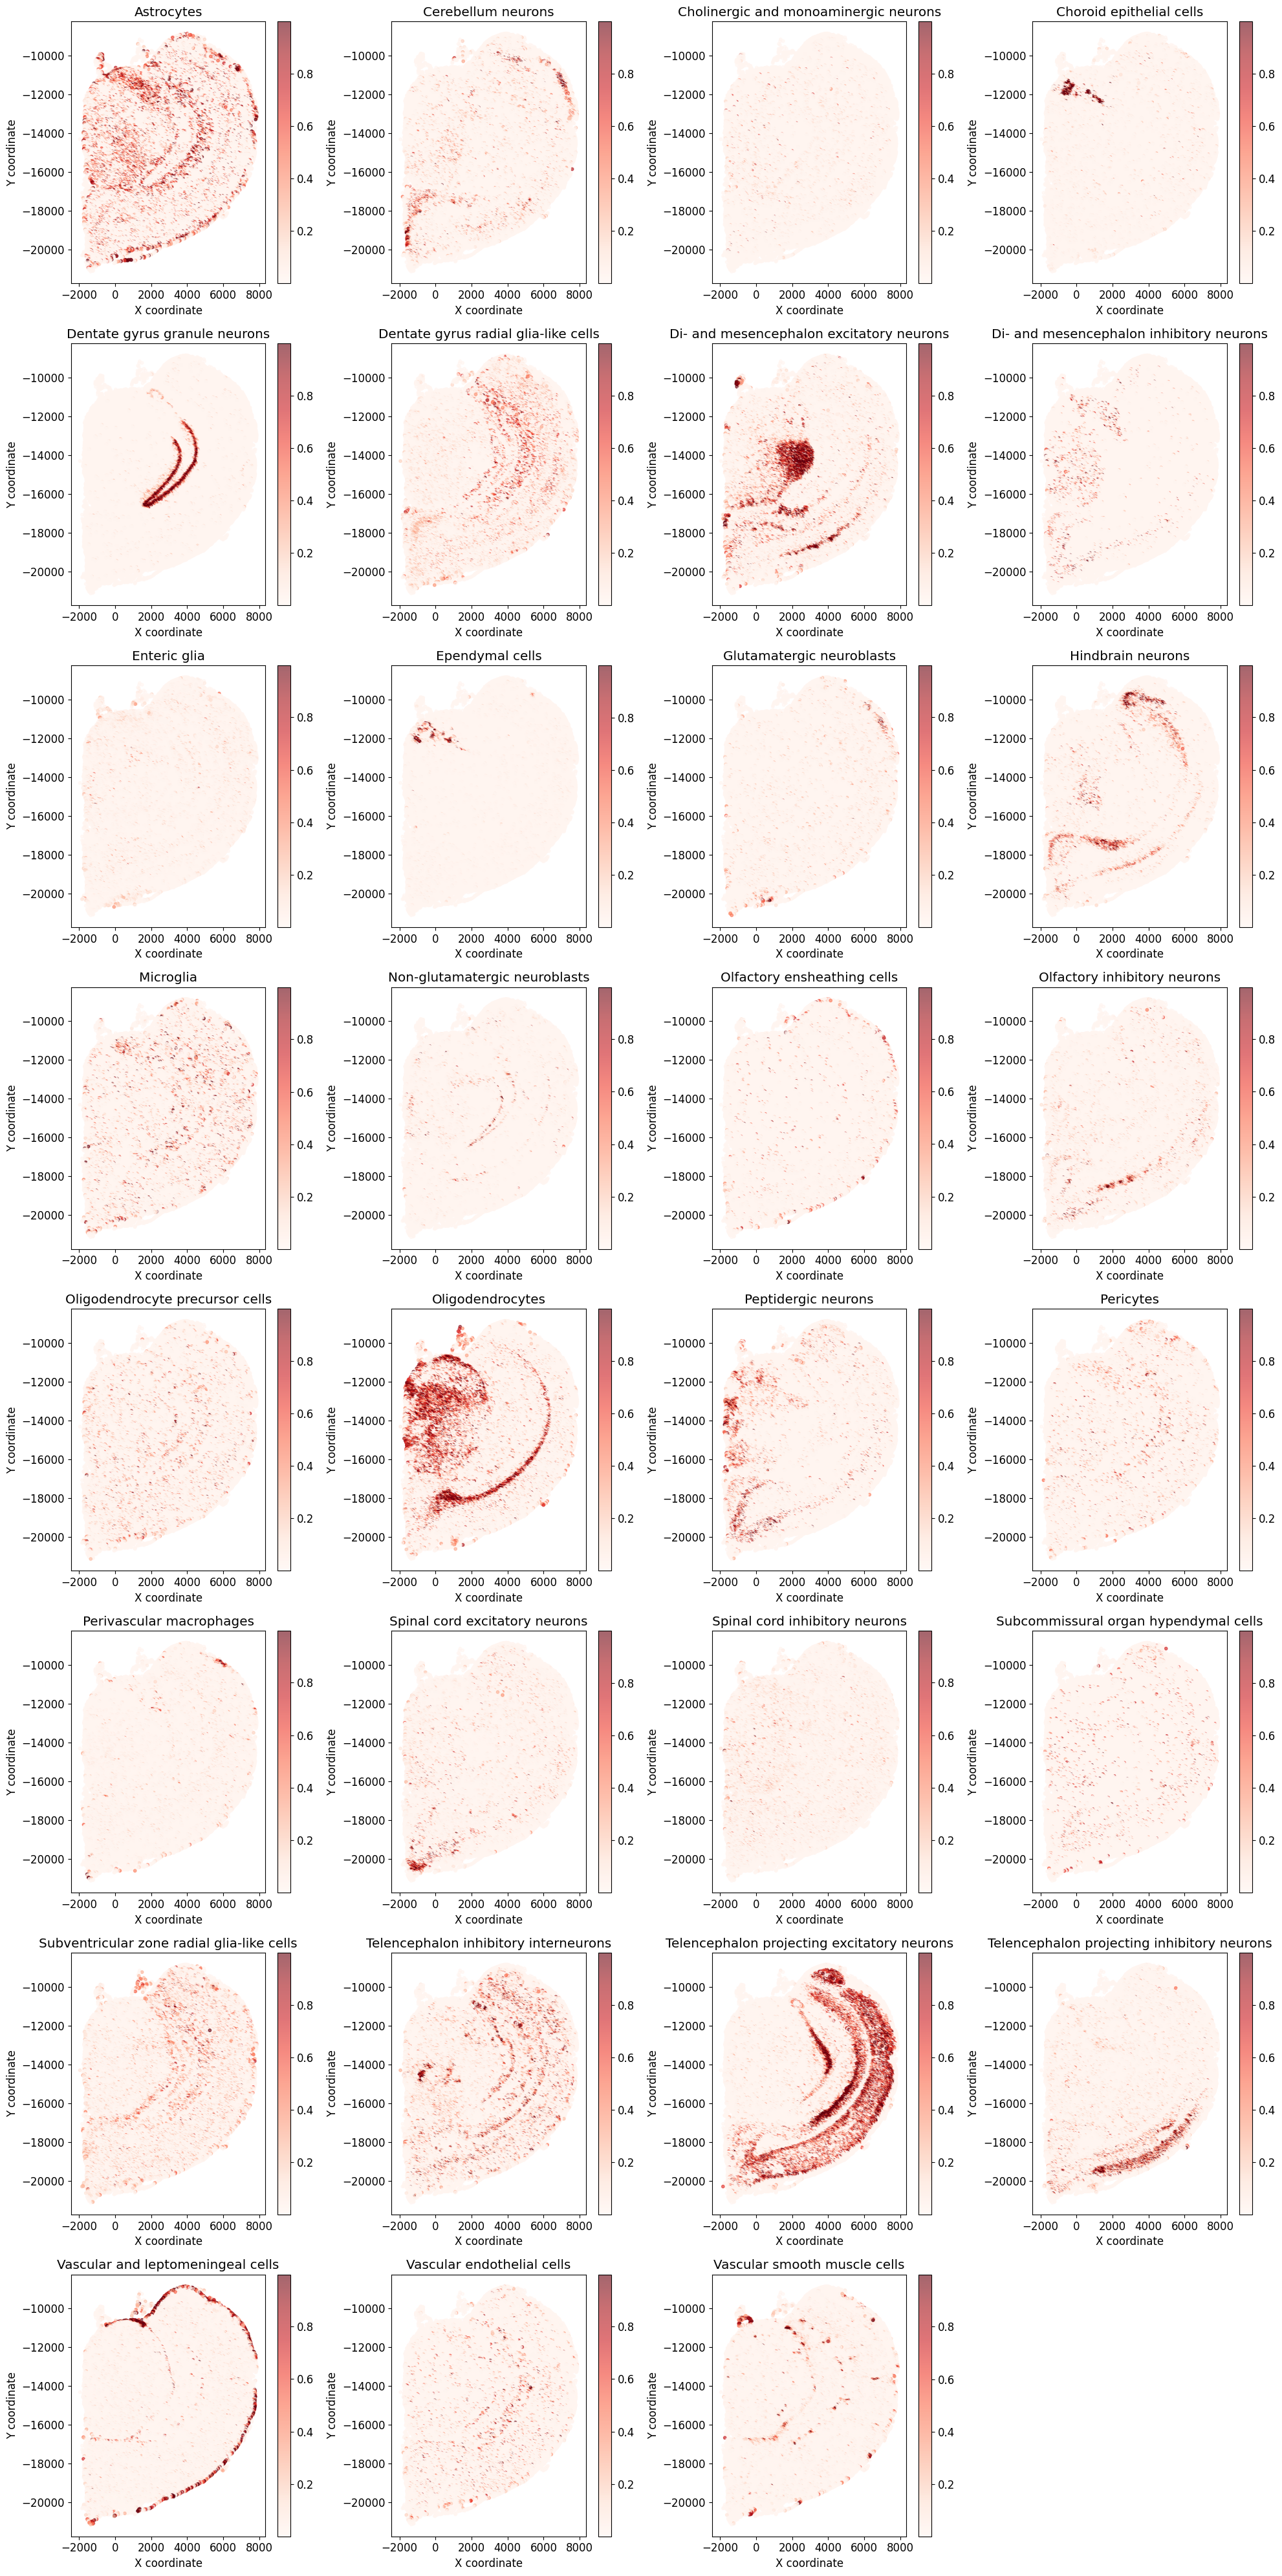

In [19]:
# plot each spot with color showing a cell type light/strong
# Create a figure with subplots for each cell type
img_cate = img_cate[:-1]  # remove 'nan'
n_cell_types = len(img_cate)
n_cols = 4  # You can adjust this
n_rows = (n_cell_types + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# Get spatial coordinates from the Stereo-seq data
spatial_coords = np.array([ad_sp.obs['x'].astype(float), 
                          ad_sp.obs['y'].astype(float)]).T

# Plot each cell type separately
for idx, cell_type in enumerate(img_cate):
    ax = axes[idx]
    
    # Get the proportions for this cell type from M_final
    cell_type_proportions = M_final[idx, :]
    
    # Create scatter plot
    scatter = ax.scatter(spatial_coords[:, 0], 
                        spatial_coords[:, 1],
                        c=cell_type_proportions,
                        cmap='Reds',
                        alpha=0.6,
                        s=10)
    
    ax.set_title(f'{cell_type}')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    fig.colorbar(scatter, ax=ax)

# Remove empty subplots if any
for idx in range(len(img_cate), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()
